## Research: adding argmin/max features

**Note:** re-targetting topleft point in this version of the notebook.

Can we still do `.forward` when we caluclate features from X in a non-differentiable way? Yes.

In this notebook we look at:
  
  - Visualizing the additional features created by using argmax/argmin on an unflattened image.
  
  - Construct `BaseNet`, a simple NN and examine the effect of changing the hidden layer size when training on the top-left-point task.
  
  - Construct `FeatsNet` which has ability to turn on/off the additional argmin/max features to before running the thru BaseNet-style model. We'll examine the benefits of adding these features.
  

### Setup - imported from previous books

In [1]:
import os, sys
import copy as copyroot
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
from fastai2.basics import *
from fastai2.vision.all import *
from sklearn.preprocessing import StandardScaler
%load_ext autoreload
%autoreload 2
from module.mnist_helpers import build_df, eda_fig_1
from module.mnist_helpers import img_pt_plot, train_history_dualplot

path = untar_data(URLs.MNIST_TINY)
df = build_df(path)
df.head(2)

y_names = [
    'point_topleft_x', 
    'point_topleft_y',
    'point_center_x',
    'point_center_y'
    ]

db =   DataBlock(blocks=(ImageBlock(cls=PILImageBW), 
                         PointBlock), 
                splitter=RandomSplitter(seed=0),
                get_x=ColReader('fn', pref=path),
                )

db_1_topleft = copyroot.deepcopy(db)
db_1_center  = copyroot.deepcopy(db)
db_2         = copyroot.deepcopy(db)

def set_get_y(db, cr):
    db.get_y = cr
    db.getters[db.n_inp:] = L(db.get_y)

set_get_y( db_1_topleft, ColReader(y_names[:2]) )
set_get_y( db_1_center,  ColReader(y_names[2:]) )
set_get_y( db_2,         ColReader(y_names) )

dl_1_topleft = db_1_topleft.dataloaders(df)
dl_1_center  = db_1_center.dataloaders(df)
dl_2         = db_2.dataloaders(df)

dls = dl_1_topleft
x, y = dls.one_batch()
x_2 = x[:2]
x_2.shape

torch.Size([2, 1, 28, 28])

### Visualize the observation and exapnded feature set
"expanded feature set" created via argmin/argmax

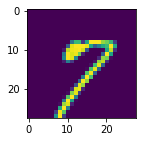

In [2]:
plt.figure(figsize=(2,2)); plt.imshow(x_2[0].squeeze(0));

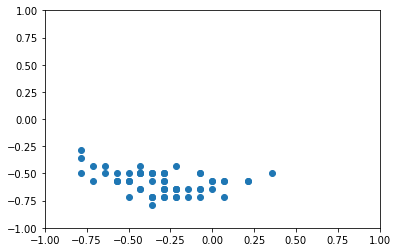

In [3]:
plt.scatter(y.squeeze(1).numpy()[:,0], y.squeeze(1).numpy()[:,1])
plt.xlim(-1,1); plt.ylim(-1,1);

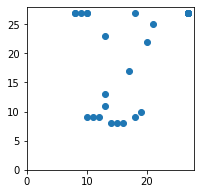

In [24]:
max2 = x_2[0].argmax(dim=1)
max3 = x_2[0].argmax(dim=2)
plt.figure(figsize=(3,3))
plt.scatter(max3, max2);
plt.xlim(0,28); plt.ylim(0,28);

### Experiments on Feature developments

In [31]:
x_sample = x_2[0]

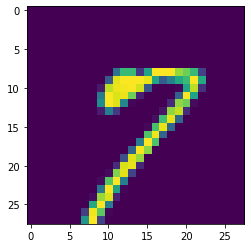

In [35]:
plt.imshow(x_sample[0,:,:])

In [157]:
mins = x_sample.nonzero().min(0)

min1 = mins.values[1]

min1_min2 = x_sample[:,min1,:].nonzero().min(0).values[1].item()

mins, min1, min1_min2

(torch.return_types.min(
 values=tensor([0, 8, 7]),
 indices=tensor([110,  11, 108])),
 tensor(8),
 11)

In [ ]:
nz   = x_sample[0,:,:].nonzero()
mins = nz.min(0)
maxs = nz.max(0)

mins

min1_min2 = x_sample[:,min1,:].nonzero().min(0).values[1].item()

mins, min1, min1_min2

### Experiments on differentials
Below we see some function preserve grad_fn like `clamp` while others do not, like `argmax`.

In [127]:
maybe = x_sample.clone().detach().requires_grad_(True)

In [143]:
maybe.grad_fn is None

True

In [153]:
maybe[:2].grad_fn

In [146]:
maybe.clamp(0).grad_fn

In [148]:
maybe.matmul(torch.ones_like(maybe)).grad_fn

In [154]:
maybe.argmax().grad_fn

In [155]:
maybe.nonzero().grad_fn

### --------

In [104]:
q.values

tensor([0, 8, 7])

In [110]:
nzt

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0],
        [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,
          9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16,
         17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 22,
         22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 25, 26, 26, 26, 26,
      

In [96]:
nzt

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0],
        [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,
          9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16,
         17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 22,
         22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 25, 26, 26, 26, 26,
      

In [81]:
nz.min(0)

torch.return_types.min(
values=tensor([0, 8, 7]),
indices=tensor([110,  11, 108]))

In [71]:
nzz = nz.reshape((111,3,1,1))
nzz.shape

torch.Size([111, 3, 1, 1])

In [76]:
nzz.min(dim=2)

torch.return_types.min(
values=tensor([[[ 0],
         [ 8],
         [11]],

        [[ 0],
         [ 8],
         [12]],

        [[ 0],
         [ 8],
         [13]],

        [[ 0],
         [ 8],
         [14]],

        [[ 0],
         [ 8],
         [15]],

        [[ 0],
         [ 8],
         [16]],

        [[ 0],
         [ 8],
         [17]],

        [[ 0],
         [ 8],
         [18]],

        [[ 0],
         [ 8],
         [19]],

        [[ 0],
         [ 8],
         [20]],

        [[ 0],
         [ 8],
         [21]],

        [[ 0],
         [ 8],
         [22]],

        [[ 0],
         [ 9],
         [10]],

        [[ 0],
         [ 9],
         [11]],

        [[ 0],
         [ 9],
         [12]],

        [[ 0],
         [ 9],
         [13]],

        [[ 0],
         [ 9],
         [14]],

        [[ 0],
         [ 9],
         [15]],

        [[ 0],
         [ 9],
         [16]],

        [[ 0],
         [ 9],
         [17]],

        [[ 0],
         [ 9],

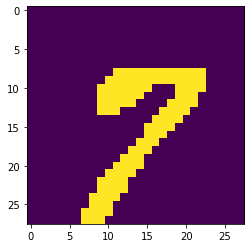

In [42]:
plt.imshow(x_sample_10[0,:,:])

(0, 28)

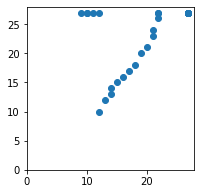

In [47]:
plt.figure(figsize=(3,3,))
plt.scatter(x_sample_10.argmax(2), x_sample_10.argmax(1))
plt.xlim(0,28); plt.ylim(0,28)

(0, 28)

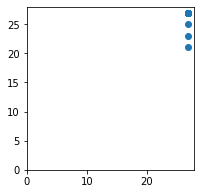

In [48]:
plt.figure(figsize=(3,3,))
plt.scatter(x_sample_10.argmin(2), x_sample_10.argmin(1))
plt.xlim(0,28); plt.ylim(0,28)

In [ ]:
esp = 1e-6
tmp = x_sample.add(eps)


In [29]:
x_2[0][0,:2,:]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]])

In [27]:
x_2[0].argmax(1)

tensor([[27, 27, 27, 27, 27, 27, 27, 27, 27, 25, 23, 22,  9, 10,  9, 17,  8,  8,
          8, 13, 11,  9,  9, 27, 27, 27, 27, 27]])

In [25]:
max2

tensor([[27, 27, 27, 27, 27, 27, 27, 27, 27, 25, 23, 22,  9, 10,  9, 17,  8,  8,
          8, 13, 11,  9,  9, 27, 27, 27, 27, 27]])

In [26]:
max3

tensor([[27, 27, 27, 27, 27, 27, 27, 27, 18, 21, 13, 20, 10, 19, 18, 17, 16, 15,
         14, 13, 13, 12, 11, 10, 10,  9,  8,  8]])

In [22]:
max2

tensor([[27, 27, 27, 27, 27, 27, 27, 25, 23, 21, 27, 27, 27, 27, 27, 27, 27, 27,
         27, 27, 27, 27, 27, 27, 27, 27, 27, 27]])

In [23]:
max3

tensor([[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
         27, 27, 27, 27, 27, 27, 27, 27, 27, 27]])

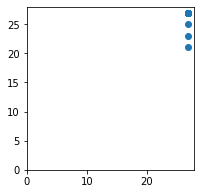

In [21]:
max2 = x_2[0].argmin(dim=1)
max3 = x_2[0].argmin(dim=2)
plt.figure(figsize=(3,3))
plt.scatter(max3, max2);
plt.xlim(0,28); plt.ylim(0,28);

### BaseNet 
Simple one hidden layer network

In [6]:
class BaseNet(torch.nn.Module):
    def __init__(self, D_in=28, H=28):
        super(BaseNet, self).__init__()
        self.flat    = nn.Flatten()
        self.linear1 = nn.Linear(in_features=D_in**2, out_features=H)
        self.linear2 = nn.Linear(in_features=H, out_features=2, bias=False)
        self.sig     = SigmoidRange(-1., 1)
    
    def forward(self, x):
        l0 = self.flat(x)
        l1 = self.linear1(l0)
        l2 = self.linear2(l1)
        y =  self.sig(l2)
        return y

In [7]:
basenet = BaseNet(28,28)
basenet(x_2)

tensor([[0.0517, 0.0010],
        [0.0201, 0.0131]], grad_fn=<AddBackward0>)

In [8]:
basenet = BaseNet(D_in=28, H=28)
learn_bn = Learner(dls, basenet, loss_func=MSELossFlat() )
learn_bn.fit(5)

epoch,train_loss,valid_loss,time
0,0.092272,0.037163,00:01
1,0.064739,0.043197,00:01
2,0.052743,0.029988,00:01
3,0.043662,0.024530,00:01
4,0.037391,0.024226,00:01


#### Test the effect of hidden layer size, `H`

In [ ]:
TRIALS = 5
EPOCHS = 8
d_mse = {}

for _h in (2, 12, 28, 52):
    
    print(f'H: {_h}')
    d_mse[_h] = []
    for trial in range(TRIALS):
        
        learn = Learner(dls, BaseNet(D_in=28, H=_h), 
                        loss_func=MSELossFlat())

        with learn.no_logging(): learn.fit(EPOCHS)

        preds = learn.get_preds()
        _mse = mse(preds[0], preds[1])
        d_mse[_h].append(_mse)

In [10]:
df_mse = pd.DataFrame({k:[e.item() for e in v] for k,v in d_mse.items()})

df_mse = df_mse.T

df_mse['avg'] = df_mse.apply(np.mean, axis=1)
df_mse['min'] = df_mse.apply(np.min, axis=1)
df_mse['max'] = df_mse.apply(np.max, axis=1)

df_mse.iloc[:, -3:].round(4)

,avg,min,max
2,0.0309,0.0257,0.0393
12,0.0228,0.0218,0.0240
28,0.0218,0.0213,0.0223
52,0.0205,0.0200,0.0216


In [11]:
df_mse.to_csv('rcnnm-3-dfmse.csv')

So there is a benefit (but decreasing returns) to adding more hidden layers from 2 thru 52, overall reducing error 30%.

### Build a NN with a variable amount of features

TODO - do standard scaling on min/max features

In [12]:
class FeatsNet(torch.nn.Module):
    
    def __init__(self, D_in=28, H=28, feats=['pix']):
        
        self.feats = feats
        self.D = D_in
        
        super(FeatsNet, self).__init__()
        
        len_ins = 0
        if 'pix'      in self.feats: len_ins += D_in**2
        if 'max'      in self.feats: len_ins += D_in*2
        if 'min'      in self.feats: len_ins += D_in*2
        if len_ins == 0: 
            raise Exception('Need a valid code in `feats`')
            
        self.flat    = nn.Flatten()
        
        self.linear1 = nn.Linear(in_features=len_ins, out_features=H)
        self.linear2 = nn.Linear(in_features=H,       out_features=2, 
                                 bias=False)
        
        self.sig     = SigmoidRange(-1., 1)
        
    def build_feats(self, x):
        
        l0 = torch.tensor([])
        
        if 'pix' in self.feats:
            l0 = self.flat(x)
        
        if 'max' in self.feats:
            max2  = self.flat(x.argmax(dim=2).float()) / float(self.D)
            max3  = self.flat(x.argmax(dim=3).float()) / float(self.D)
            l0 = torch.cat((l0, max2, max3), dim=1)
            
        if 'min' in self.feats:    
            min2  = self.flat(x.argmin(dim=2).float()) / float(self.D)
            min3  = self.flat(x.argmin(dim=3).float()) / float(self.D)
            l0 = torch.cat((l0, min2, min3), dim=1)
            
        return l0
    
    def forward(self, x):
        
        l0 = self.build_feats(x)
        
        l1 = self.linear1(l0)
        l2 = self.linear2(l1)
        y =  self.sig(l2)
        return y

##### Show the change in feature size based on inputs requested in `feats`

In [13]:
def fn_info(feats):
    fn = FeatsNet(feats=feats)
    x2_feats = fn.build_feats(x_2)
    print(f'feats: {str(feats).ljust(25)} | {x2_feats.shape}')

feats = ['pix',]
fn_info(feats)

feats = ['pix', 'max']
fn_info(feats)

feats = ['min', 'max']
fn_info(feats)

feats = ['pix', 'min', 'max']
fn_info(feats)

feats: ['pix']                   | torch.Size([2, 784])
feats: ['pix', 'max']            | torch.Size([2, 840])
feats: ['min', 'max']            | torch.Size([2, 112])
feats: ['pix', 'min', 'max']     | torch.Size([2, 896])


##### Run Sample Models
With original feature set vs. expanded featrue set  

In [14]:
fn = FeatsNet(feats=['pix'])
learn = Learner(dls, fn, loss_func=MSELossFlat())
learn.fit(10)

epoch,train_loss,valid_loss,time
0,0.108367,0.034981,00:01
1,0.072713,0.042994,00:01
2,0.059658,0.034711,00:01
3,0.050120,0.024851,00:01
4,0.042739,0.026633,00:01
5,0.037477,0.022372,00:02
6,0.033185,0.021803,00:01
7,0.029932,0.021141,00:01
8,0.027228,0.021205,00:01
9,0.025016,0.020097,00:01


In [15]:
fn = FeatsNet(feats=['pix','min', 'max'])
learn = Learner(dls, fn, loss_func=MSELossFlat())
learn.fit(10)

epoch,train_loss,valid_loss,time
0,0.076443,0.054700,00:01
1,0.061238,0.030257,00:01
2,0.047024,0.028117,00:01
3,0.039082,0.020843,00:01
4,0.033603,0.020015,00:01
5,0.029254,0.018178,00:01
6,0.025882,0.017377,00:01
7,0.023168,0.017034,00:01
8,0.020991,0.017724,00:01
9,0.019216,0.015124,00:01


So the additional features push model err below the asymptote, we're on the right track

#### Build Table of Results
Fit multiple times a model with differnet feature sets, and record the validation mse. Compare results below:

In [16]:
TRIALS = 5
EPOCHS = 8
d_mse = {}

for feats in (['pix'], ['pix', 'min'], ['pix', 'max'],
              ['pix','min','max']):
    
    k = '|'.join(feats)
    print(f'feats: {k}')
    d_mse[k] = []
    
    for trial in range(TRIALS):
        
        learn = Learner(dls, FeatsNet(feats=feats), 
                        loss_func=MSELossFlat())
        with learn.no_logging(): learn.fit(EPOCHS)
        preds = learn.get_preds()
        _mse = mse(preds[0], preds[1])
        d_mse[k].append(_mse)

feats: pix


feats: pix|min


feats: pix|max


feats: pix|min|max


In [17]:
df_mse = pd.DataFrame({k:[e.item() for e in v] for k,v in d_mse.items()})

df_mse = df_mse.T

df_mse['avg'] = df_mse.apply(np.mean, axis=1)
df_mse['min'] = df_mse.apply(np.min, axis=1)
df_mse['max'] = df_mse.apply(np.max, axis=1)

df_mse.iloc[:, -3:].round(4)

,avg,min,max
pix,0.0216,0.0208,0.0227
pix|min,0.0177,0.0164,0.0183
pix|max,0.0182,0.0170,0.0192
pix|min|max,0.0167,0.0155,0.0175


In [18]:
df_mse.to_csv('rcnnm-3-dfmse-featsnet.csv')

Excellent, the additional features perform better than the with the original featue set, reducing error by 15-30%. (They also have more variance).

It appaears the `min` features are more beneficial ones here? (Whereas for center point only `max` feats were valuable).

The `min` features being valuable doesn't seem to make much sense in light of the paucity of information contained, as seen in the first section.